In [73]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import missingno as msno
from ydata_profiling import ProfileReport

#pre processamento
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

#modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


#metricas
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, auc, roc_curve, average_precision_score
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score

#outros
import time
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from collections import Counter
import pickle


pd.set_option('display.max_columns', None)

In [74]:
customer = pd.read_csv('Churn_Modelling.csv')

In [75]:
customer.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Basic data cleaning

In this step we are going to drop some useless columns, correct possible typos in the column names ,check for duplicates and correct casting.

In [76]:
customer.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [77]:
#dropping useless columns
customer = customer.drop(columns=["RowNumber", "CustomerId", "Surname"])

In [78]:
customer.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [79]:
#looking for missing values
customer.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<Axes: >

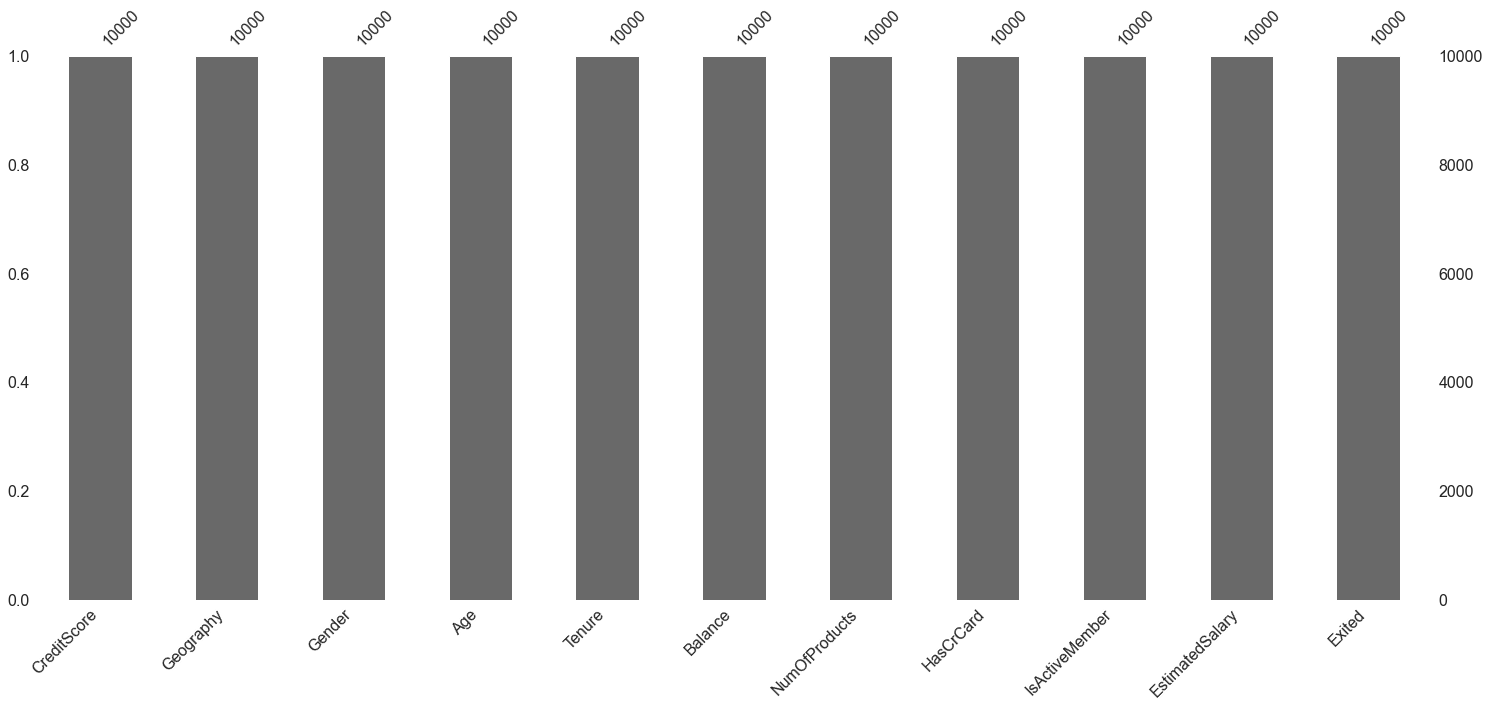

In [80]:
msno.bar(customer)

A princípio, sem problemas com valores nulos.

In [81]:
#checking duplicates
customer.duplicated().sum()

0

Também não temos valores duplicados

In [82]:
# checking for typos on the categorical variables
customer_cat = customer.select_dtypes('object').columns

for col in customer_cat:
    print(customer[col].value_counts())

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
Gender
Male      5457
Female    4543
Name: count, dtype: int64


In [83]:
#Tipos de Dados
customer.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

# EDA

In [84]:
customer.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


- **Age**: A idade média dos clientes é de 39 anos, variando de 18 a 92.



- **Dependents:** On average, each client has 2 dependents, which could provide insight into the household size and potential financial responsibilities of the customers. 
-  **Months on book** Customers have been with the bank for an average of 35 months, which is equivalent to almost 3 years. The minimum duration is 13 months, indicating a relatively stable customer base. Understanding the tenure of customers can help identify long-term customers who may be at higher risk of churn due to changes in their financial situation or other factors.
- **Credit limit**: The average credit limit for customers is $8631. 
- **Months innactive on the last year:** On average, customers have been inactive for 2 months in the last year. 

In [85]:
#categorial variables
customer.describe(include='object').T

,count,unique,top,freq
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


- Mostly of the client base is women, have higher education, are married and earn less tha $40.000 per year.

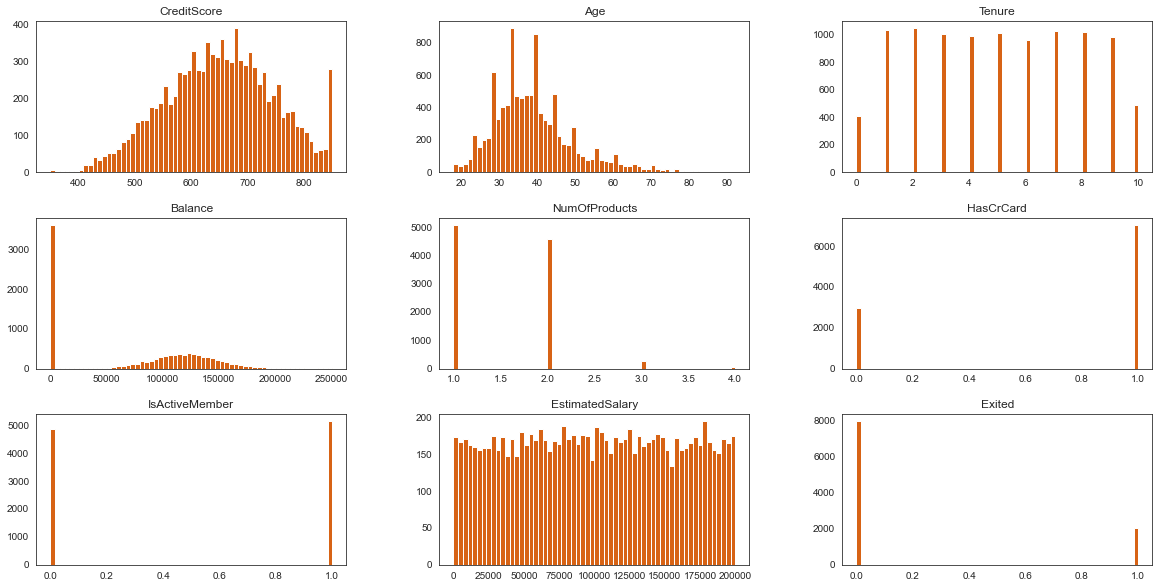

In [86]:
customer.hist(bins=60, grid= False, figsize=(20,10), color = '#D76315')
plt.show()

## Outliers


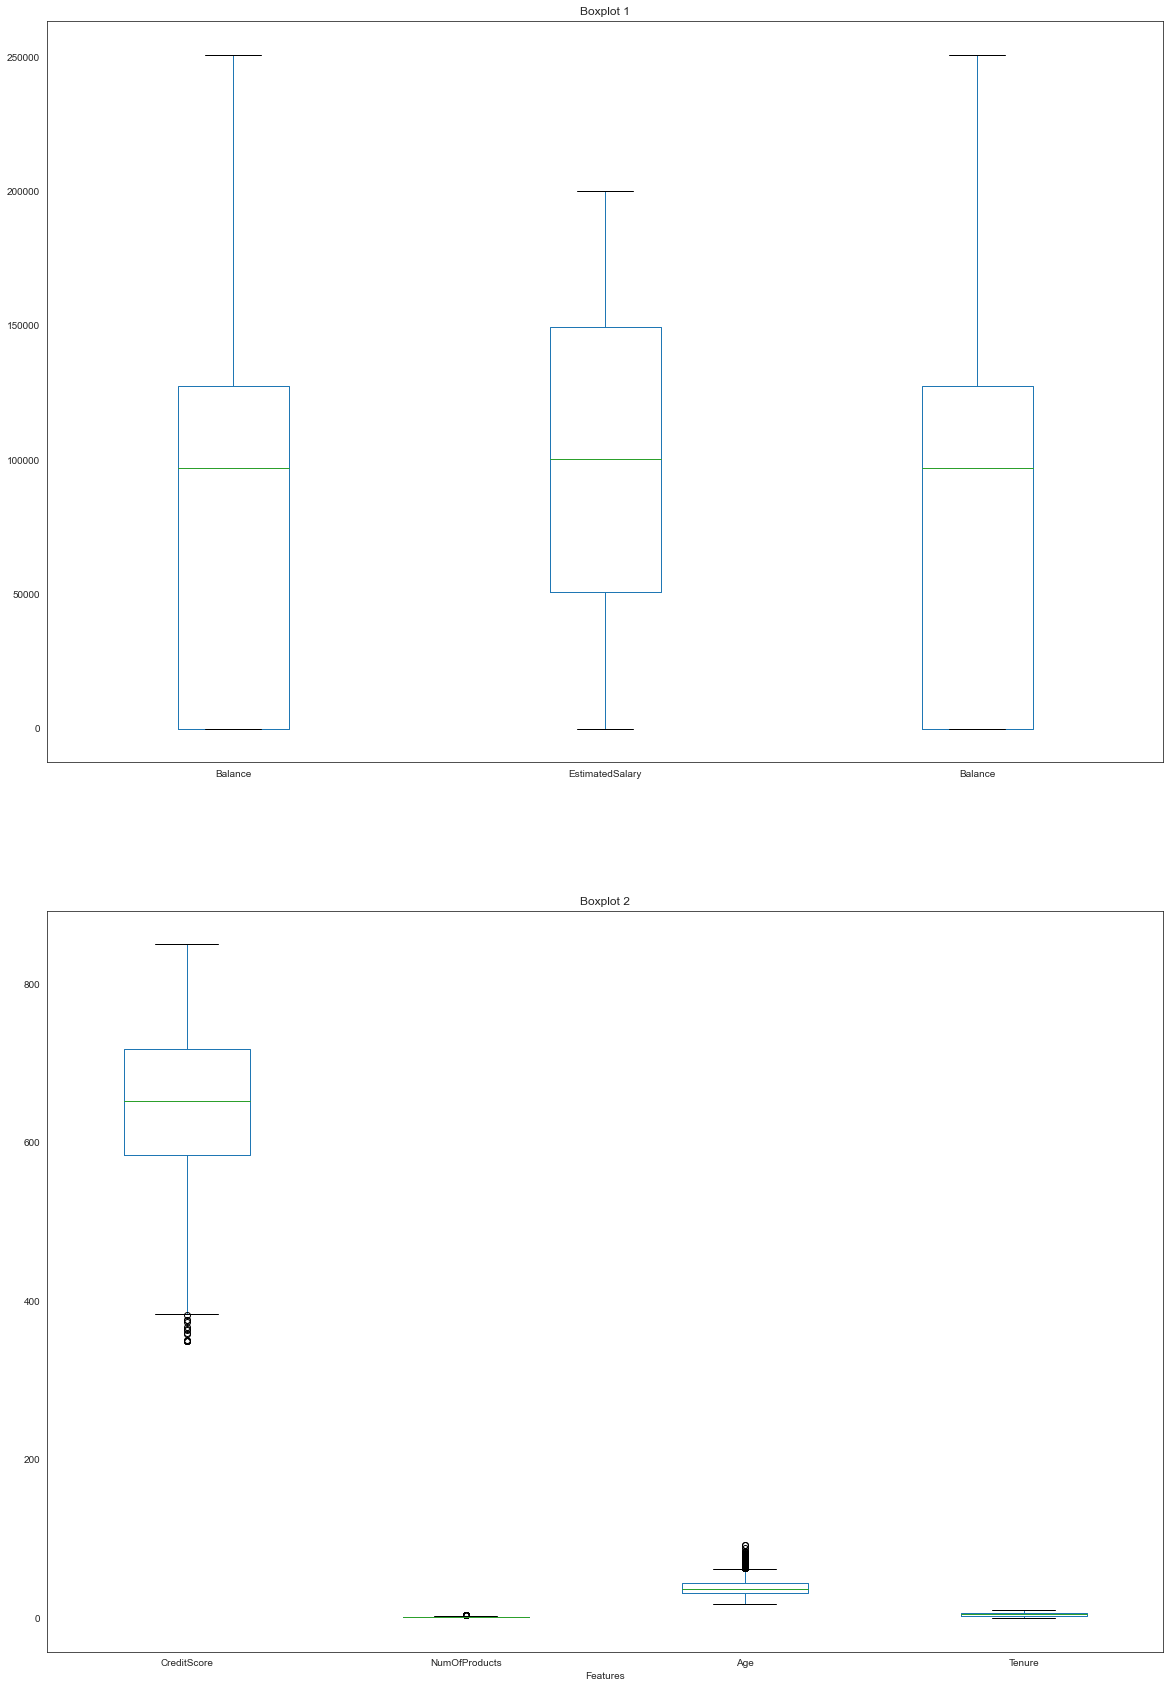

In [87]:
#Create a figure with multiple subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 30))

# Plot the first set of columns in the first subplot
customer.boxplot(column=['Balance', 'EstimatedSalary',
                         'Balance'], ax=axes[0], grid= False)
axes[0].set_title('Boxplot 1')


# Plot the first set of columns in the first subplot
customer.boxplot(column=['CreditScore','NumOfProducts',
                         'Age', 'Tenure',
                         ], ax=axes[1], grid= False)
axes[1].set_title('Boxplot 2')

# Add a common x-axis label and adjust spacing between subplots
plt.xlabel('Features')
plt.subplots_adjust(hspace=0.2)

# Show the plot
plt.show()



We don't have many outliers in this dataset.

## Univariate analysis

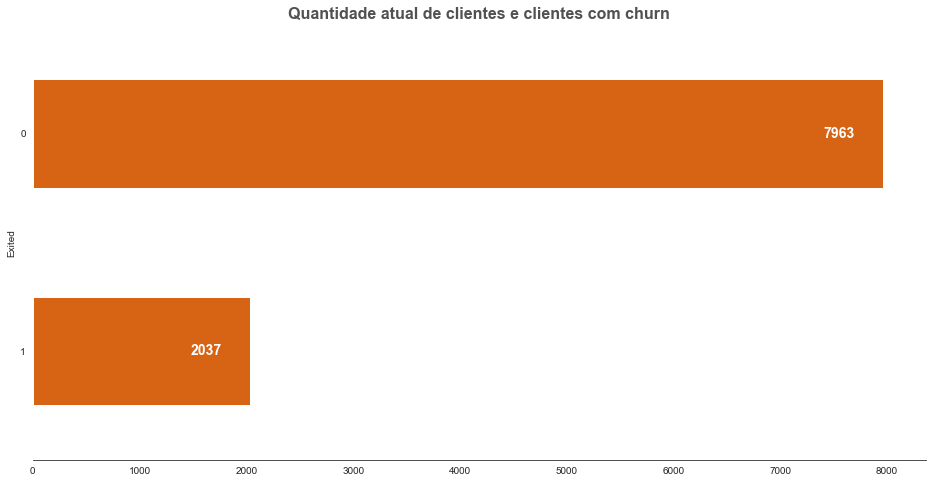

In [88]:
#Clientes com Churn
afg = (customer['Exited'].value_counts().sort_values(ascending = True)
      .plot(kind = 'barh', color = ['#D76315'], xlabel = '', figsize = (16,8), align = 'center'))

plt.title('Quantidade atual de clientes e clientes com churn', size = 16, weight = 'bold', alpha = 0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(bottom = False, left = False)

rects = afg.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = - 60
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha,
        color = 'white',
        weight = 'bold',
            size = 14)                      
plt.show()

There is way more 'Existing Customer' than 'Attrited Customer'. We can see that the dataset has imbalanced classes.

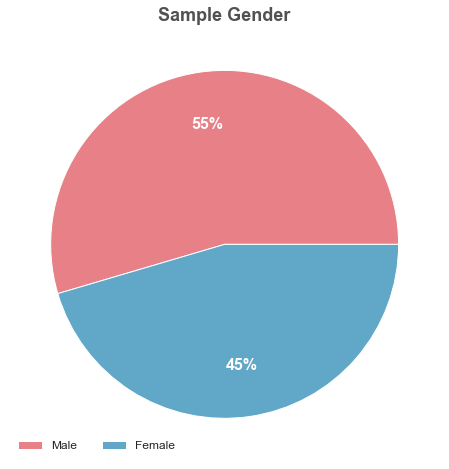

In [89]:
#genero
colors = ['#e88087', '#61A7C8']
(customer['Gender'].value_counts().plot.pie(autopct='%1.0f%%', ylabel = '',
                                           figsize=(16,8), legend=True,
                                           labeldistance=None,
                                           textprops={'fontsize':16, 'color':'white', 'weight':'bold'},
                                           pctdistance= 0.7, colors = colors))
plt.title('Sample Gender', alpha = 0.8, size = 18, weight = 'bold')
plt.legend(loc = 3, frameon=False, fontsize = 12, ncol=3)
plt.show()

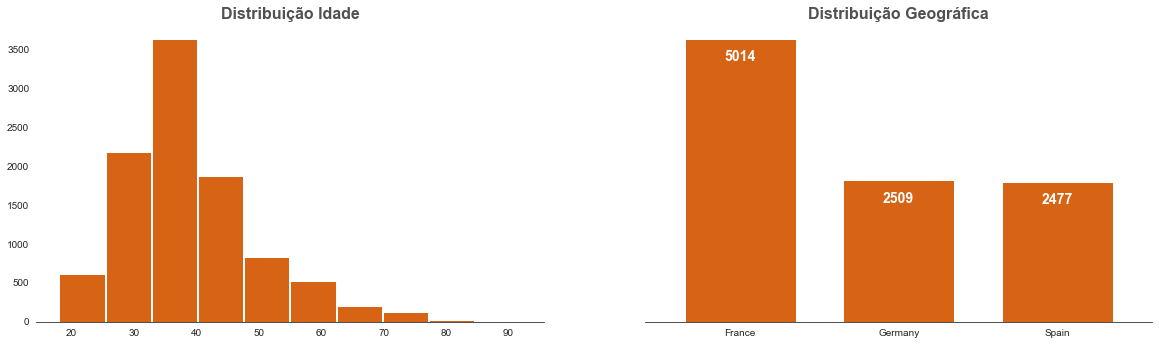

In [90]:
# Subplot 1 - Age
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
customer['Age'].hist(grid=False, color='#D76315', rwidth=0.98)
plt.title('Distribuição Idade', alpha=0.8, size=16, weight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(bottom=False, left=False)

# Subplot 2 - Geography
plt.subplot(2, 2, 2)
geo = (customer['Geography'].value_counts().plot(kind='bar', rot=0,  width=0.7,
                                                       color='#D76315'))  
#                                                      color=['#D76315', '#EEA05A', '#EEA05A', '#EEA05A']))
plt.title('Distribuição Geográfica', size=16, alpha=0.8, weight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(bottom=False, left=False)
plt.xlabel('')
plt.yticks([])

for rect in geo.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = -25
    va = 'bottom'
    if y_value < 0:
        space *= -1
        va = 'top'
    label = "{:.0f}".format(y_value)
    geo.annotate(
        label,
        (x_value, y_value),
        xytext=(0, space),
        textcoords="offset points",
        ha='center',
        va=va,
        color='white',
        size=14,
        weight='bold')

               
plt.show()

- A maior parte da amostra consiste em adultosde 30-50 years.
- Os clientes estão distribuídos entre frança, alemanha e espanha, com a maior parte na frança

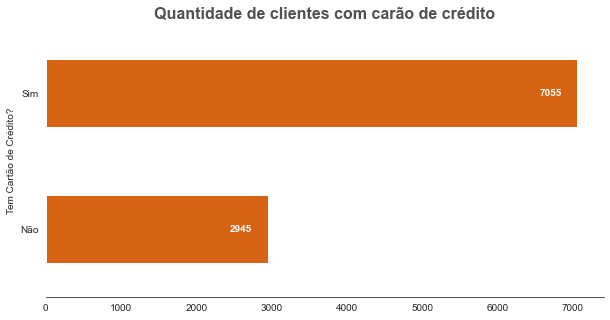

In [91]:
ax = (customer['HasCrCard'].map({0: 'Não', 1: 'Sim'}).value_counts().sort_values(ascending = True)
      .plot(kind = 'barh', color = ['#D76315'], xlabel = '', figsize = (10,5), align = 'center'))

plt.title('Quantidade de clientes com carão de crédito', size = 16, weight = 'bold', alpha = 0.8)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(bottom = False, left = False)
plt.ylabel('Tem Cartão de Crédito?')

for bar in ax.patches:
    width = bar.get_width()
    plt.text(width - 500,                             # posição x (um pouco à direita do fim da barra)
             bar.get_y() + bar.get_height() / 2,      # posição y (meio da barra)
             str(int(width)),                         # valor como texto
             va='center',
             color = 'white',
             weight='bold'
            )                           # alinhamento vertical centralizado


## Bivariate Analysis

In [92]:
customer


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [93]:
#creating the crosstab to do the plots
gender_crstab= pd.crosstab(customer['Gender'], customer['Exited'].map({0: 'Não', 1: 'Sim'}))
gender_crstab['% Churn'] = gender_crstab['Sim']/(gender_crstab['Não'] + gender_crstab['Sim'])

geo_crstab = pd.crosstab(customer['Geography'], customer['Exited'].map({0: 'Não', 1: 'Sim'}))
geo_crstab['% Churn'] = geo_crstab['Sim']/(geo_crstab['Não'] + geo_crstab['Sim'])

crcard_crstab = pd.crosstab(customer['HasCrCard'].map({0: 'Sem Cartão', 1: 'Com Cartão'}), customer['Exited'].map({0: 'Não', 1: 'Sim'}))
crcard_crstab['% Churn'] = crcard_crstab['Sim']/(crcard_crstab['Não'] + crcard_crstab['Sim'])

nprod_crstab = pd.crosstab(customer['NumOfProducts'], customer['Exited'].map({0: 'Não', 1: 'Sim'}))
nprod_crstab['% Churn'] = nprod_crstab['Sim']/(nprod_crstab['Não'] + nprod_crstab['Sim'])

print('Gender cross tab:')
print(gender_crstab)
print('-' * 60)
print('')
print('Geography cross tab:')
print(geo_crstab)
print('-' * 60)
print('')
print('Credit Card cross tab:')
print(crcard_crstab)
print('-' * 60)
print('')
print('Number of Products cross tab:')
print(nprod_crstab)



Gender cross tab:
Exited   Não   Sim   % Churn
Gender                      
Female  3404  1139  0.250715
Male    4559   898  0.164559
------------------------------------------------------------

Geography cross tab:
Exited      Não  Sim   % Churn
Geography                     
France     4204  810  0.161548
Germany    1695  814  0.324432
Spain      2064  413  0.166734
------------------------------------------------------------

Credit Card cross tab:
Exited       Não   Sim   % Churn
HasCrCard                       
Com Cartão  5631  1424  0.201843
Sem Cartão  2332   613  0.208149
------------------------------------------------------------

Number of Products cross tab:
Exited          Não   Sim   % Churn
NumOfProducts                      
1              3675  1409  0.277144
2              4242   348  0.075817
3                46   220  0.827068
4                 0    60  1.000000


In [94]:
gender_crstab.drop('% Churn', axis=1, inplace=True)
geo_crstab.drop('% Churn', axis=1, inplace=True)
crcard_crstab.drop('% Churn', axis=1, inplace=True)
nprod_crstab.drop('% Churn', axis=1, inplace=True)


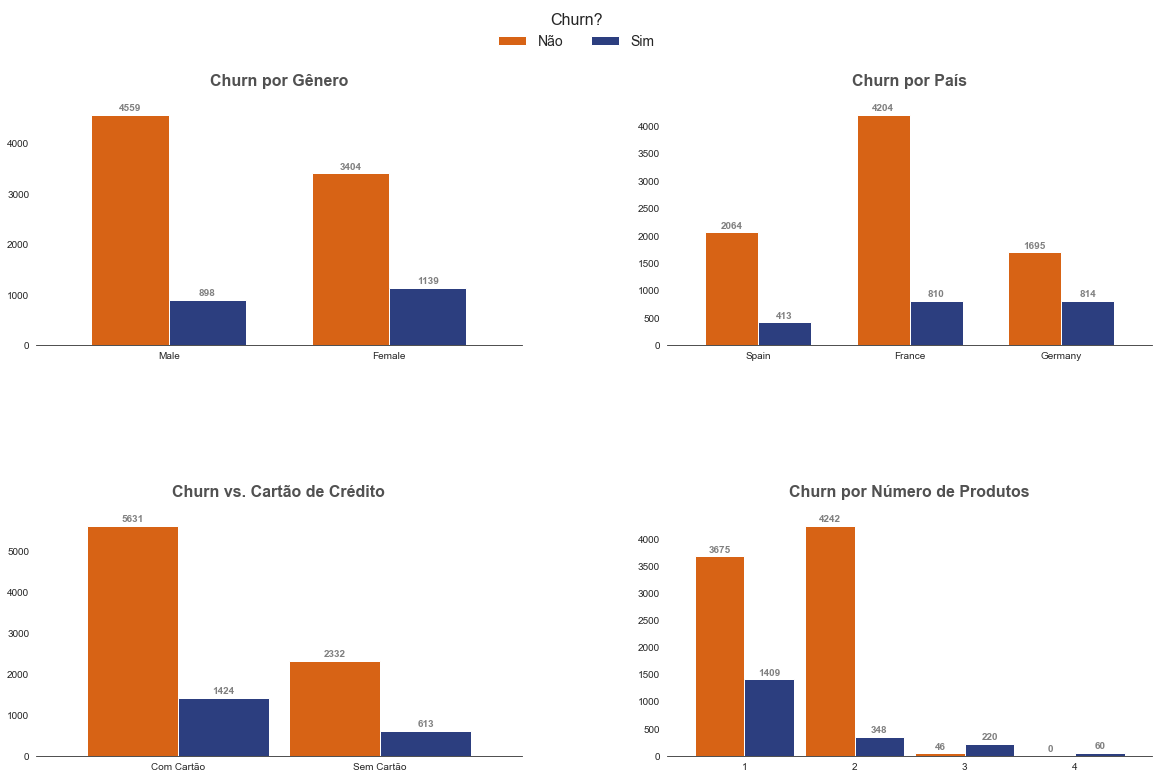

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

#Subplot 1: Gender
gender_crstab_plot = gender_crstab.sort_values(['Sim'], ascending= True).plot(kind='bar', rot = 0, width = 0.7, xlabel = '', color = ['#D76315','#2C3E7F'], legend = None, ax=axes[0, 0])
axes[0, 0].set_title('Churn por Gênero', size = 16, alpha = 0.8, weight = 'bold', y=1.05)
axes[0, 0].spines['top'].set_visible(False)
axes[0, 0].spines['right'].set_visible(False)
axes[0, 0].spines['left'].set_visible(False)
axes[0, 0].tick_params(bottom = False, left = False)

for rect in gender_crstab_plot.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 2
    va = 'bottom'

    if y_value < 0:
        space *= -1
        va = 'top'

    label = "{:.0f}".format(y_value)

    gender_crstab_plot.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va,
        color = 'gray',
        size = 10,
        weight = 'bold')                      
    


#Subplot 2: Geography
geo_crstab_plot = geo_crstab.sort_values(['Sim'], ascending= True).plot(kind='bar', rot = 0, width = 0.7, xlabel = '', color = ['#D76315','#2C3E7F'], legend = None, ax=axes[0, 1])
axes[0, 1].set_title('Churn por País', size = 16, alpha = 0.8, weight = 'bold', y=1.05)
axes[0, 1].spines['top'].set_visible(False)
axes[0, 1].spines['right'].set_visible(False)
axes[0, 1].spines['left'].set_visible(False)
axes[0, 1].tick_params(bottom = False, left = False)

for rect in geo_crstab_plot.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 2
    va = 'bottom'

    if y_value < 0:
        space *= -1
        va = 'top'

    label = "{:.0f}".format(y_value)

    geo_crstab_plot.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va,
        color = 'gray',
        size = 10,
        weight = 'bold')                      
    


#Subplot 3: Credit Card Status
crcard_crstab_plot = crcard_crstab.sort_values(['Sim'], ascending= False).plot(kind='bar', rot = 0, width = 0.9, xlabel = '',color = ['#D76315','#2C3E7F'], legend = None,ax=axes[1, 0])
axes[1, 0].set_title('Churn vs. Cartão de Crédito', size = 16, alpha = 0.8, weight = 'bold', y=1.05)
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)
axes[1, 0].spines['left'].set_visible(False)
axes[1, 0].tick_params(bottom = False, left = False)


for rect in crcard_crstab_plot.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 2
    va = 'bottom'

    if y_value < 0:
        space *= -1
        va = 'top'

    label = "{:.0f}".format(y_value)

    crcard_crstab_plot.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va,
        color = 'gray',
        size = 10,
        weight = 'bold')   

#Subplot 4: Number of Products
nprod_crstab_plot = nprod_crstab.plot(kind='bar', rot = 0, width = 0.9, xlabel = '', color = ['#D76315','#2C3E7F'], legend = None,ax=axes[1, 1])
axes[1, 1].set_title('Churn por Número de Produtos', size = 16, alpha = 0.8, weight = 'bold',y=1.05)
axes[1, 1].spines['top'].set_visible(False)
axes[1, 1].spines['right'].set_visible(False)
axes[1, 1].spines['left'].set_visible(False)
axes[1, 1].tick_params(bottom = False, left = False)

for rect in nprod_crstab_plot.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 2
    va = 'bottom'

    if y_value < 0:
        space *= -1
        va = 'top'

    label = "{:.0f}".format(y_value)

    nprod_crstab_plot.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va,
        color = 'gray',
        size = 10,
        weight = 'bold')   



plt.subplots_adjust(hspace=0.7, wspace=0.3)

handles, labels = axes[0, 0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2, frameon=False, title = 'Churn?', fontsize = 14)
legend.get_title().set_fontsize(16)


plt.show()


In [96]:
total_balance_churn = customer[['Balance', 'Exited']].groupby(['Balance', 'Exited']).size().reset_index(name='Count')
df_pivot_balance = total_balance_churn.pivot(index='Balance', columns='Exited', values='Count')

total_tenure_churn = customer[['Tenure', 'Exited']].groupby(['Tenure', 'Exited']).size().reset_index(name='Count')
df_pivot_tenure = total_tenure_churn.pivot(index='Tenure', columns='Exited', values='Count')


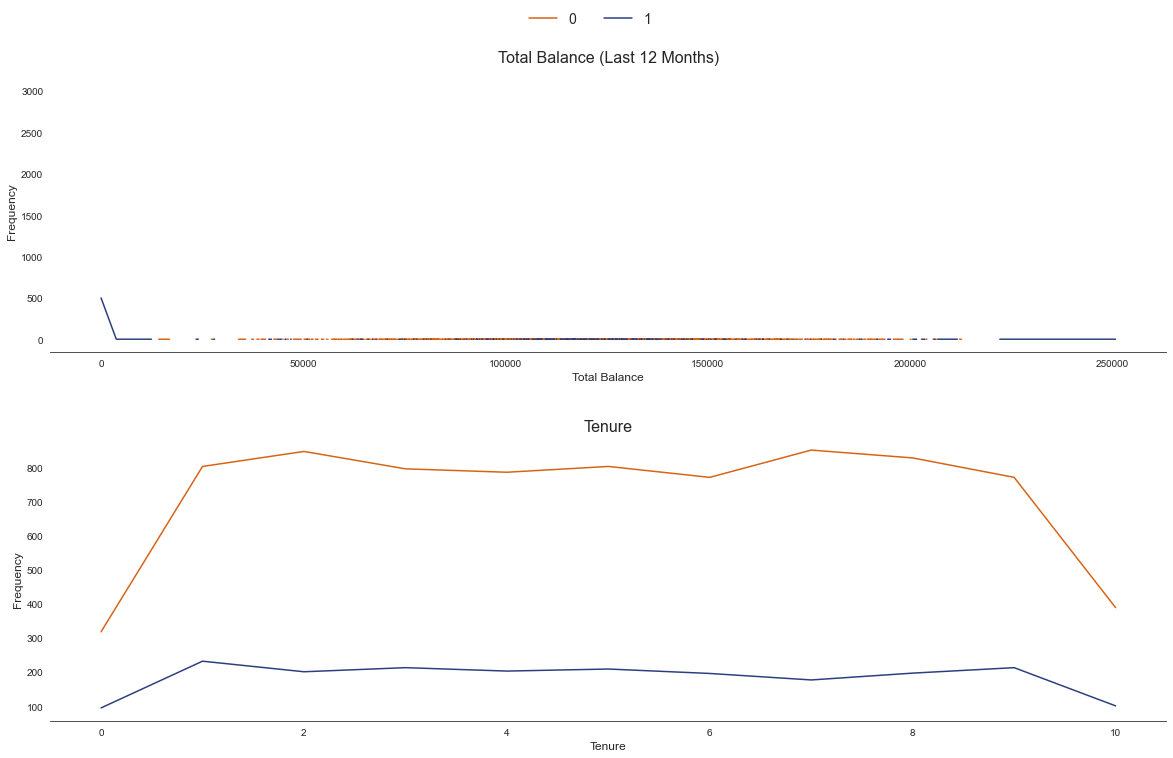

In [97]:
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Subplot 1:
plt.subplot(2, 1, 1)
plt.plot(df_pivot_balance.index, df_pivot_balance[0], color='#D76315', label=0)
plt.plot(df_pivot_balance.index, df_pivot_balance[1], color='#2C3E7F', label=1)
plt.title('Total Balance (Last 12 Months)', fontsize=16)
plt.xlabel('Total Balance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().tick_params(bottom=False, left=False)

# Subplot 2:
plt.subplot(2, 1, 2)
plt.plot(df_pivot_tenure.index, df_pivot_tenure[0], color='#D76315', label=0)
plt.plot(df_pivot_tenure.index, df_pivot_tenure[1], color='#2C3E7F', label=1)
plt.title('Tenure', fontsize=16)
plt.xlabel('Tenure', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().tick_params(bottom=False, left=False)


plt.subplots_adjust(hspace=0.3, wspace=0.3)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=2, frameon=False, fontsize=14)
plt.show()


## Correlations

In [98]:
# mask = np.triu(np.ones_like(customer.corr(), dtype=bool))
# sns.set(rc = {'figure.figsize':(20, 12)})
# sns.heatmap(customer.corr(), mask=mask,  annot=True, cmap='RdBu')

Some notable correlations in this dataset are:
- Months on the book has a high correlation with customer age (0.79)
- Total relationship count has an inverse correlation with total transition amount and total transition count (-0.35 and -0.25, respectively)
- Average Open to Buy has a perfect correlation with Credit Limit.
- Credit Limit has an inverse correlation with Average Utilization Ratio (-0.48)
- Average Utilization Ratio has a positive correlation with Total Revolving Bal (0.62) but has an inverse correlation with Average Open to Buy (-0.54)

# Data Preparation

In this step, we will prepare the data for analysis and the machine learning process.
The project has two main goals:

    i. Construct a machine learning model capable of predicting which customers are likely to churn.
    
    ii. Use the predictions to perform a cluster analysis on customers who have the potential to churn, in order to understand their characteristics and approach them in a personalized manner.

The entire workflow is:

![Framewokr](pictures/framework.png)

In [99]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### Class: To churn or to not churn

### Spliting the columns 

In [100]:
y_all = customer.loc[:, 'Exited']
X_all = customer.drop('Exited', axis = 1)

In [101]:
print(len(X_all))
print(len(y_all))
print(y_all.value_counts(normalize=True))

10000
10000
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


### Categorical Encoding

In this dataset, we have a series of categorical data. However, some machine learning algorithms do not perform well with categorical data, which is why it is necessary to convert them into numeric data. One of the most popular methods for doing this is by applying a process called One Hot Encoding, where we create dummy variables with values of 0 or 1 to represent the categorical variables.

I chose to use One Hot Encoding as the only method to transform the variables (instead of applying Label Encoding to some other variables) because I intend to work with clustering algorithms later on, and they tend to perform better with this type of encoding. Additionally, I dropped the first dummy variable to avoid multicollinearity in the data, which can impact the performance of the machine learning model.

In [102]:
X_all.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71
6,822,France,Male,50,7,0.00,2,1,1,10062.80
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88
8,501,France,Male,44,4,142051.07,2,0,1,74940.50
9,684,France,Male,27,2,134603.88,1,1,1,71725.73


In [103]:
X_all.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [104]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop='first'), ['Geography', 'Gender']),
    remainder= 'passthrough'
)

In [105]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['Geography', 'Gender'])])

In [106]:
X_all

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


In [107]:
transformed = transformer.fit_transform(X_all)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

In [108]:
transformed_df.columns

Index(['onehotencoder__Geography_Germany', 'onehotencoder__Geography_Spain',
       'onehotencoder__Gender_Male', 'remainder__CreditScore',
       'remainder__Age', 'remainder__Tenure', 'remainder__Balance',
       'remainder__NumOfProducts', 'remainder__HasCrCard',
       'remainder__IsActiveMember', 'remainder__EstimatedSalary'],
      dtype='object')

In [109]:
transformed_df = transformed_df.rename(columns = {'onehotencoder__Geography_Germany' : 'Geography_Germany', 
                                                  'onehotencoder__Geography_Spain' : 'Geography_Spain',
                                                  'onehotencoder__Gender_Male' : 'Gender_Male', 
                                                  'remainder__CreditScore' : 'CreditScore',
                                                  'remainder__Age' : 'Age', 
                                                  'remainder__Tenure' : 'Tenure', 
                                                  'remainder__Balance' : 'Balance',
                                                  'remainder__NumOfProducts':'NumOfProducts', 
                                                  'remainder__HasCrCard' : 'HasCrCard',
                                                  'remainder__IsActiveMember' : 'IsActiveMember', 
                                                  'remainder__EstimatedSalary' : 'EstimatedSalary'
                                                 })
    
    

In [110]:
customer

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [111]:
transformed_cus = transformer.fit_transform(customer)
transformed_cus_df = pd.DataFrame(transformed_cus, columns=transformer.get_feature_names_out())

In [112]:
transformed_cus_df

,onehotencoder__Geography_Germany,onehotencoder__Geography_Spain,onehotencoder__Gender_Male,remainder__CreditScore,remainder__Age,remainder__Tenure,remainder__Balance,remainder__NumOfProducts,remainder__HasCrCard,remainder__IsActiveMember,remainder__EstimatedSalary,remainder__Exited
0,0.0,0.0,0.0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0
1,0.0,1.0,0.0,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0
2,0.0,0.0,0.0,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0
3,0.0,0.0,0.0,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0
4,0.0,1.0,0.0,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,1.0,771.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64,0.0
9996,0.0,0.0,1.0,516.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77,0.0
9997,0.0,0.0,0.0,709.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58,1.0
9998,1.0,0.0,1.0,772.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52,1.0


In [113]:
transformed_cus_df = transformed_cus_df.rename(columns = {'onehotencoder__Geography_Germany' : 'Geography_Germany', 
                                                  'onehotencoder__Geography_Spain' : 'Geography_Spain',
                                                  'onehotencoder__Gender_Male' : 'Gender_Male', 
                                                  'remainder__CreditScore' : 'CreditScore',
                                                  'remainder__Age' : 'Age', 
                                                  'remainder__Tenure' : 'Tenure', 
                                                  'remainder__Balance' : 'Balance',
                                                  'remainder__NumOfProducts':'NumOfProducts', 
                                                  'remainder__HasCrCard' : 'HasCrCard',
                                                  'remainder__IsActiveMember' : 'IsActiveMember', 
                                                  'remainder__EstimatedSalary' : 'EstimatedSalary',
                                                  'remainder__Exited' : 'Exited'        
                                                 })
    
    

In [114]:
transformed_cus_df

,Geography_Germany,Geography_Spain,Gender_Male,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.0,0.0,0.0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,1.0
1,0.0,1.0,0.0,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0
2,0.0,0.0,0.0,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,1.0
3,0.0,0.0,0.0,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0
4,0.0,1.0,0.0,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,1.0,771.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64,0.0
9996,0.0,0.0,1.0,516.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77,0.0
9997,0.0,0.0,0.0,709.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58,1.0
9998,1.0,0.0,1.0,772.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52,1.0


In [115]:
transformed_cus_df.corr()['Exited']

Geography_Germany    0.173488
Geography_Spain     -0.052667
Gender_Male         -0.106512
CreditScore         -0.027094
Age                  0.285323
Tenure              -0.014001
Balance              0.118533
NumOfProducts       -0.047820
HasCrCard           -0.007138
IsActiveMember      -0.156128
EstimatedSalary      0.012097
Exited               1.000000
Name: Exited, dtype: float64

### Splitting the data

In [116]:
X_train, X_test, y_train, y_test = train_test_split(transformed_df, y_all, test_size=0.2, random_state = 42, shuffle=True)

In [117]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 11)
(8000,)
(2000, 11)
(2000,)


### Scaling
I employed the MinMaxScaler as the normalization technique in my data preprocessing pipeline. This step is crucial for optimizing the algorithm's runtime and mitigating issues such as overshooting.

In [118]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [119]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_Y.fit_transform(y_train.reshape(-1, 1)).ravel()
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_Y.transform(y_test.reshape(-1, 1)).ravel()

In [120]:
# y_train_array = y_train.values.ravel()
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# y_train_scaled = scaler.fit_transform(y_train_array.reshape(-1, 1)).ravel()

# Churn Prediction

### Model Selection

I utilized multiple machine-learning classifiers to predict the churn status of customers. The selected classifiers were Logistic Regression (used as a baseline), Decision Tree, Random Forest, and XGBoost. As the dataset was imbalanced, I applied the Synthetic Minority Over-sampling Technique (SMOTE) to the training set to address this issue and improve the performance of the classifiers.

To assess the performance of the models, I employed cross-validation with 5 folds. This involved dividing the original data into different folds for training and testing purposes. The training set was used for model training, while the test set was used for evaluating the performance of the models.

In order to evaluate the performance of the classifiers, I measured accuracy, precision, recall, and F1-scores. However, I considered recall as the main metric for assessing the models. Recall is a vital metric as it represents the proportion of positive examples that are predicted correctly. It is particularly important in imbalanced datasets where accurately predicting positive instances (such as churned customers) is critical for decision-making and business impact.

In [121]:

def cross_validation(model, X, y, oversampling=True):
    # Scikit-learn K-Fold
    kfold = StratifiedKFold(n_splits=5)

    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []
    

    for idx, (idx_train, idx_validation) in enumerate(kfold.split(X, y)):
        X_train_split = X[idx_train, :]
        y_train_split = y[idx_train]

        if oversampling:
            sm = SMOTE(random_state=42)
            X_train_split, y_train_split = sm.fit_resample(X_train_split, y_train_split)

        model.fit(X_train_split, y_train_split)

        X_validation_split = X[idx_validation, :]
        y_validation_split = y[idx_validation]

        predictions = model.predict(X_validation_split)

        fold_accuracy = accuracy_score(y_validation_split, predictions)
        fold_precision = precision_score(y_validation_split, predictions)
        fold_recall = recall_score(y_validation_split, predictions)
        fold_f1 = f1_score(y_validation_split, predictions)

        fold_accuracies.append(fold_accuracy)
        fold_precisions.append(fold_precision)
        fold_recalls.append(fold_recall)
        fold_f1s.append(fold_f1)
    

    print(f'Overall accuracy: {np.mean(fold_accuracies)}')
    print(f'Overall precision: {np.mean(fold_precisions)}')
    print(f'Overall recall: {np.mean(fold_recalls)}')
    print(f'Overall F1-score: {np.mean(fold_f1s)}')
    
    return fold_accuracies, fold_precisions, fold_recalls, fold_f1s



In [122]:
models = [LogisticRegression(),  DecisionTreeClassifier(), RandomForestClassifier(), xgb.XGBClassifier()]

for model in models:
    print(f'Cross-validation for {type(model).__name__}:')
    cross_validation(model, X_train_scaled, y_train_scaled)
    print('------------------------------------------------------------')


Cross-validation for LogisticRegression:


c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.w

Overall accuracy: 0.709
Overall precision: 0.3839915919911338
Overall recall: 0.6855141226184298
Overall F1-score: 0.4921400050410094
------------------------------------------------------------
Cross-validation for DecisionTreeClassifier:


c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.w

Overall accuracy: 0.7743749999999999
Overall precision: 0.46025288532466513
Overall recall: 0.5602287048706354
Overall F1-score: 0.5050210363301983
------------------------------------------------------------
Cross-validation for RandomForestClassifier:


c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.w

Overall accuracy: 0.8422500000000002
Overall precision: 0.620620648059871
Overall recall: 0.6003428719697531
Overall F1-score: 0.6098520708834976
------------------------------------------------------------
Cross-validation for XGBClassifier:


c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.w

Overall accuracy: 0.845125
Overall precision: 0.6469567099143329
Overall recall: 0.5468344577062791
Overall F1-score: 0.5915321704704783
------------------------------------------------------------


In [123]:
X_train_scaled

array([[0.        , 0.        , 1.        , ..., 1.        , 1.        ,
        0.89555028],
       [1.        , 0.        , 1.        , ..., 1.        , 1.        ,
        0.98002868],
       [0.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.42926087],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.46092526],
       [0.        , 0.        , 1.        , ..., 1.        , 0.        ,
        0.48738065],
       [1.        , 0.        , 1.        , ..., 1.        , 1.        ,
        0.26761502]])

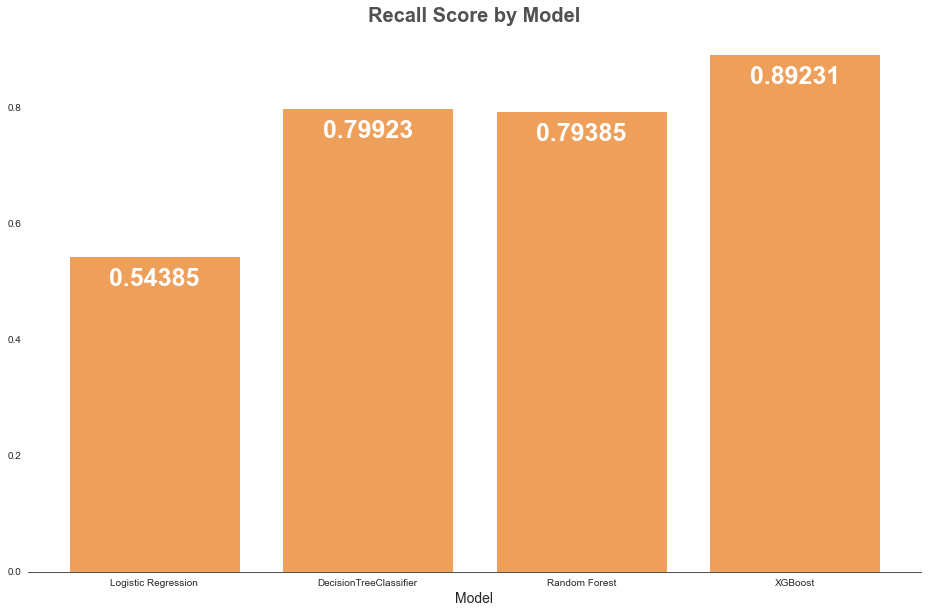

In [124]:
# List of models and their respective Recall scores
models = ['Logistic Regression', 'DecisionTreeClassifier', 'Random Forest', 'XGBoost']
recall_scores = [0.5438461538461539,0.7992307692307692, 0.7938461538461539, 0.8923076923076924]

# Create the bar chart
sns.set_style("white")
fig, ax = plt.subplots(figsize=(16, 10))

ax.bar(models, recall_scores, color='#EEA05A')

# Add labels to axes and the chart
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('', fontsize=14)
ax.set_title('Recall Score by Model', size=20, weight='bold', alpha=0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(bottom=False, left=False)
sns.set_style("white")

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = -35
    va = 'bottom'

    if y_value < 0:
        space *= -1
        va = 'top'

    label = "{:.5f}".format(y_value)

    ax.annotate(
        label,
        (x_value, y_value),
        xytext=(0, space),
        textcoords="offset points",
        ha='center',
        va=va,
        color='white',
        size=25,
        weight='bold')

# Show the chart
plt.show()



## Hyperparameter Tuning

After comparing the performance of multiple machine-learning classifiers, I selected XGBoost as the best model based on its higher recall score. However, I wanted to further improve its performance, so I used grid search to tune its hyperparameters. After several iterations, I found the optimal combination of hyperparameters that resulted in the best recall score. Specifically, I adjusted the learning rate, maximum depth, and number of estimators. The final hyperparameter values were determined to be a learning rate of 0.3, maximum depth of 6, and 100 estimators. These parameters were selected after careful consideration and validation to ensure they resulted in the best possible performance of the model.

In [125]:
grid_params = {
    
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 5, 6]
    }

print(grid_params)

{'n_estimators': [10, 50, 100], 'learning_rate': [0.1, 0.2, 0.3, 0.5], 'max_depth': [3, 5, 6]}


In [ ]:
accuracy_lst_xgb = []
precision_lst_xgb = []
recall_lst_xgb = []
f1_lst_xgb = []
auc_lst_xgb = []


# Set error_score to raise in RandomizedSearchCV
xgb_grid = RandomizedSearchCV(xgb.XGBClassifier(), grid_params, random_state=42)

start = time.time()
count = 0

# Start the loop for cross-validation
for train, test in StratifiedKFold().split(X_train_scaled, y_train_scaled):
    
    # Define the imbalanced pipeline with SMOTETomek and the random forest model
    pipeline_xgb = imbalanced_make_pipeline(SMOTE(), xgb_grid)
    
    
    # Fit the pipeline to the training data
    model_xgb = pipeline_xgb.fit(X_train_scaled[train], y_train_scaled[train])
        
    # Select the best estimator from RandomizedSearchCV
    best_est_xgb = xgb_grid.best_estimator_
    
    # Make predictions on the test set
    prediction_xgb = best_est_xgb.predict(X_train_scaled[test])
    
    # Append the evaluation metrics to their respective lists
    accuracy_lst_xgb.append(pipeline_xgb.score(X_train_scaled[test], y_train_scaled[test]))
    precision_lst_xgb.append(precision_score(y_train_scaled[test], prediction_xgb))
    recall_lst_xgb.append(recall_score(y_train_scaled[test], prediction_xgb))
    f1_lst_xgb.append(f1_score(y_train_scaled[test], prediction_xgb))
    auc_lst_xgb.append(roc_auc_score(y_train_scaled[test], prediction_xgb))
    
    count = count + 1
    print(f"kfold nº: {count}")
    
    # Print the current fold number and the intermediate time
    intervalo = time.time()
    print(f"Intermediate time: {(intervalo - start)/60:.1f} minutes")
    print()
    
    # Print the best hyperparameters for the random forest model

print('---' * 20)
print(f"Best estimators for XGB: {xgb_grid.best_params_}")

# Print the mean of the evaluation metrics across all folds
print('---' * 20)
print('Results')
print(f"Accuracy:  {np.mean(accuracy_lst_xgb)}")
print(f"Precision: {np.mean(precision_lst_xgb)}")
print(f"Recall:    {np.mean(recall_lst_xgb)}")
print(f"F1:        {np.mean(f1_lst_xgb)}")
print(f"AUC:       {np.mean(auc_lst_xgb)}")
print('---' * 20)

# printing the total time of cross-validation

end = time.time()
print(f"Time of the loop for cross-validation: {(end - start)/60:.1f} minutes")

c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


kfold nº: 1
Intermediate time: 0.2 minutes



c:\users\joao_\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## Final Model

Here I train the model and predict which customers are going to churn and which ones are not. Additionally, I used feature importance to identify the parameters that had the most significant impact on the model's prediction. This analysis helped me understand which factors played a crucial role in predicting customer churn.

In [ ]:
best_estimator_xgb = xgb_grid.best_estimator_

pipeline_xgb = imbalanced_make_pipeline(SMOTE(), best_estimator_xgb)

model = pipeline_xgb.fit(X_train_scaled, y_train_scaled)


In [ ]:
importances = best_estimator_xgb.feature_importances_
features = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create horizontal bar plot
plt.figure(figsize=(20, 16))
sns.set_style("white")
plt.barh(range(X_train.shape[1]), importances[indices], color='#EEA05A')
plt.yticks(range(X_train.shape[1]), names)
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(bottom = False, left = False)
plt.show()

#### Predicting

In [ ]:
# Make predictions on the test set
prediction_xgb = model_xgb.predict(X_test_scaled)

# Evaluate the performance of the model on the test set
accuracy_xgb = pipeline_xgb.score(X_test_scaled, y_test_scaled)
precision_xgb = precision_score(y_test_scaled, prediction_xgb)
recall_xgb = recall_score(y_test_scaled, prediction_xgb)
f1_xgb = f1_score(y_test_scaled, prediction_xgb)
auc_xgb = roc_auc_score(y_test_scaled, prediction_xgb)

# Print the evaluation metrics
print('---' * 20)
print('Final Results')
print(f"Accuracy:  {accuracy_xgb}")
print(f"Precision: {precision_xgb}")
print(f"Recall:    {recall_xgb}")
print(f"F1:        {f1_xgb}")
print(f"AUC:       {auc_xgb}")
print('---' * 20)

In [ ]:
# converter o numpy.ndarray em um pandas DataFrame
df_prediction = pd.DataFrame(prediction_xgb, columns=['Prediction'])
# adicionar o índice
df_prediction.index = range(1, len(df_prediction) + 1)
# exibir o DataFrame da predição
print(df_prediction)



In [ ]:
# Create a DataFrame with the original columns of the test set
prediction_df = pd.DataFrame(X_test, columns=transformed_df.columns)

# Add the predicted values as a new column
prediction_df['prediction'] = prediction_xgb

# Print the resulting DataFrame
prediction_df.head()



In [ ]:
prediction_df['prediction'].value_counts(normalize=True)

In [ ]:
customer['Exited'].value_counts(normalize=True)